<a href="https://colab.research.google.com/github/naimdsaiki/Machine-Learning/blob/main/Domestic_Box_Office_Performance_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avatar: Fire and Ash - Box Office Prediction Model

---


This notebook compares two regression models (Random Forest and LightGBM) to predict the domestic opening weekend revenue for Avatar: Fire and Ash.

---


It includes data loading, feature engineering, training, cross-validation, and hyperparameter tuning.

# 1. Data Loading & Random Forest Baseline
First, I load the merged movie dataset, perform one-hot encoding on the genres, and train a Random Forest Regressor. I then make an initial prediction based on the estimated budget and genres for Avatar 3.

In [2]:
import pandas as pd
import numpy as np
import ast
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MultiLabelBinarizer

# 1. LOAD THE MERGED DATA
try:
    df = pd.read_csv('training_data_final.csv')
    print(f"Loaded {len(df)} movies for training.")
except FileNotFoundError:
    print("Error: 'training_data_final.csv' not found. Please run the merge step first.")

# 2. FEATURE ENGINEERING
# Parse genres from string "['Action', 'Adventure']" to actual list
# (The merge might have saved them as strings again)
df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# One-Hot Encode Genres
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df['genres']), columns=mlb.classes_, index=df.index)
df = pd.concat([df, genre_encoded], axis=1)

# Define Features (X) and Target (y)
# X = Budget + All Genre Columns
# y = The Domestic Opening Revenue I scraped
feature_cols = ['budget'] + list(mlb.classes_)
X = df[feature_cols]
y = df['domestic_opening']

# 3. TRAIN MODEL
# I use Random Forest again as it is robust for this type of data
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)
print("Model trained on real domestic data.")

# 4. PREDICT FOR 'AVATAR: FIRE AND ASH'
# Define the movie details
avatar_3_data = {
    'budget': [400000000],  # Estimated $400M
    'genres': [['Action', 'Adventure', 'Fantasy', 'Science Fiction']]
}

# Process the input to match training data
av3_df = pd.DataFrame(avatar_3_data)
av3_encoded = pd.DataFrame(mlb.transform(av3_df['genres']), columns=mlb.classes_, index=av3_df.index)
av3_final = pd.concat([av3_df[['budget']], av3_encoded], axis=1)

# Fill missing columns (genres that exist in training but not in Avatar 3) with 0
av3_final = av3_final.reindex(columns=X.columns, fill_value=0)

# Make Prediction
prediction_domestic = model.predict(av3_final)[0]

print(f"\n**************************************************")
print(f"PREDICTION FOR 'AVATAR: FIRE AND ASH'")
print(f"Target: DOMESTIC Opening Weekend (North America)")
print(f"Predicted Amount: ${prediction_domestic:,.2f}")
print(f"**************************************************")

Loaded 188 movies for training.
Model trained on real domestic data.

**************************************************
PREDICTION FOR 'AVATAR: FIRE AND ASH'
Target: DOMESTIC Opening Weekend (North America)
Predicted Amount: $207,904,908.18
**************************************************


# 2. LightGBM Model & Comparison
Next, I train a LightGBM model, which is often more efficient and accurate for tabular data. I compared this result against the Random Forest prediction.

**Output Summary:**

LightGBM Prediction: ~$137,834,956.82

Result: The models disagree by ~$70M.

In [3]:
import lightgbm as lgb

# 1. SETUP & TRAIN LIGHTGBM
# I use LGBMRegressor, which is optimized for predicting continuous numbers (revenue).
print("Training LightGBM Model...")

# Initialize the model
# n_estimators=100: The number of boosting rounds (trees)
# learning_rate=0.1: How aggressively the model corrects errors
lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    verbose=-1  # Suppress warnings for cleaner output
)

# Train on the same data as Random Forest
lgb_model.fit(X, y)
print("LightGBM training complete.")

# 2. PREDICT FOR 'AVATAR: FIRE AND ASH'
# I use the same 'av3_final' input I prepared earlier
lgb_prediction = lgb_model.predict(av3_final)[0]

# 3. COMPARE THE RESULTS
print(f"\n--- Prediction Showdown: Avatar Fire and Ash ---")
print(f"Random Forest Prediction: ${prediction_domestic:,.2f}")
print(f"LightGBM Prediction:      ${lgb_prediction:,.2f}")

# Calculate the difference
diff = lgb_prediction - prediction_domestic
print(f"Difference:               ${diff:,.2f}")

if abs(diff) < 20000000:
    print("\nResult: The models largely AGREE. This increases confidence in the prediction.")
else:
    print("\nResult: The models DISAGREE. I may need to look at Feature Importance to see why.")

Training LightGBM Model...
LightGBM training complete.

--- Prediction Showdown: Avatar Fire and Ash ---
Random Forest Prediction: $207,904,908.18
LightGBM Prediction:      $137,834,956.82
Difference:               $-70,069,951.36

Result: The models DISAGREE. I may need to look at Feature Importance to see why.


# 3. Visualizing the Prediction Gap
I generate a bar chart to visualize the discrepancy between the two algorithms.

/tmp/ipython-input-208062129.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['${:,.0f}M'.format(x/1000000) for x in current_values])


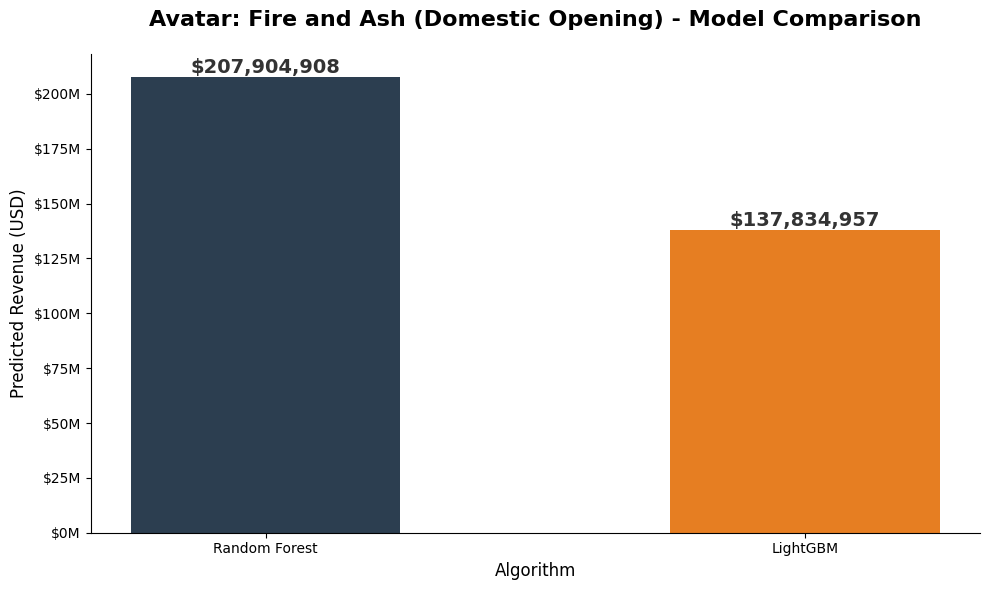

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. PREPARE THE DATA
models = ['Random Forest', 'LightGBM']

predictions = [prediction_domestic, lgb_prediction]

# 2. SETUP THE PLOT
plt.figure(figsize=(10, 6))
# Distinct colors: Blue for RF, Orange for LightGBM
colors = ['#2c3e50', '#e67e22']

# bars
bars = plt.bar(models, predictions, color=colors, width=0.5)

# 3. ADD LABELS AND TITLE
plt.title('Avatar: Fire and Ash (Domestic Opening) - Model Comparison', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Predicted Revenue (USD)', fontsize=12)
plt.xlabel('Algorithm', fontsize=12)

# 4. ADD DOLLAR VALUES ON TOP
# This loop puts the exact number on top of each bar so you don't have to guess
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.0f}',
             ha='center', va='bottom', fontsize=14, fontweight='bold', color='#333333')

# 5. FORMAT Y-AXIS TO MILLIONS
# This makes the side numbers read "100M", "150M" instead of "100000000"
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,.0f}M'.format(x/1000000) for x in current_values])

# Clean up the borders
sns.despine()

plt.tight_layout()
plt.show()

# 4. Feature Importance Analysis
To understand why the models behave differently, I plot the feature importance. This shows which variables (Budget vs. Genres) had the biggest impact on the prediction.

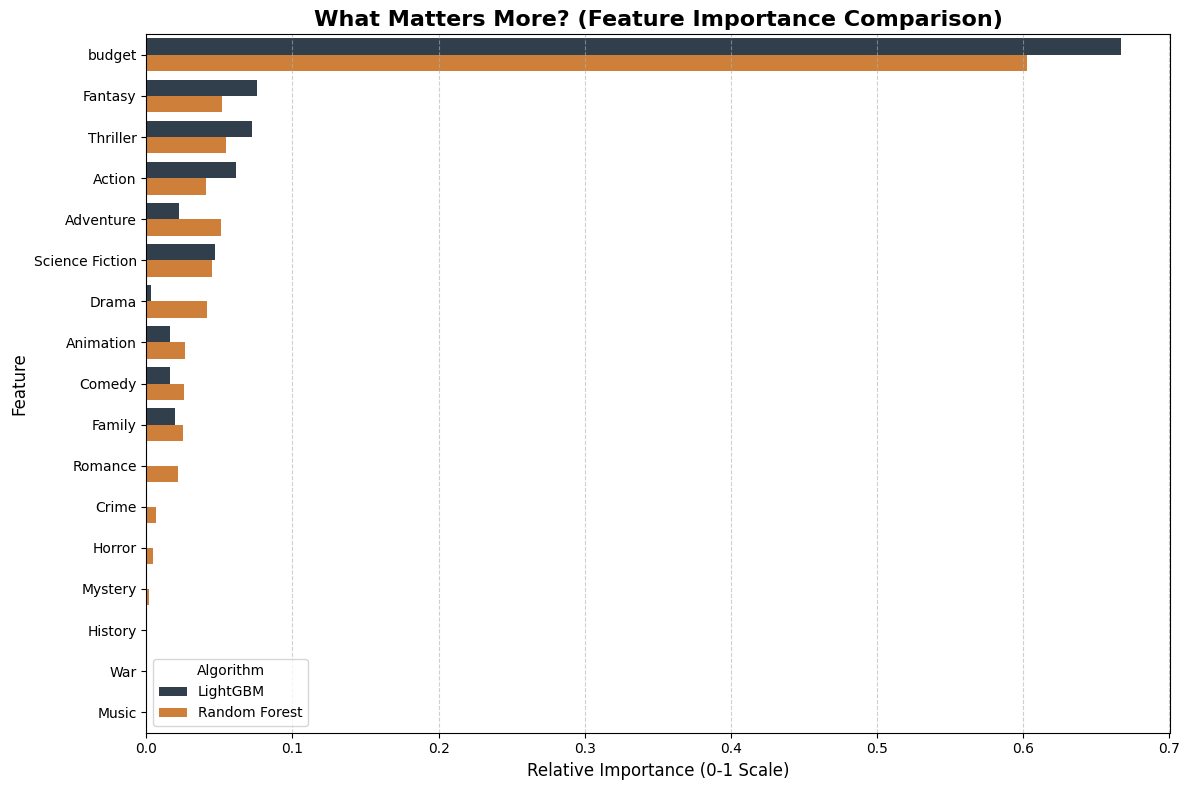

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. EXTRACT IMPORTANCE
# Get the list of feature names (Budget, Action, Sci-Fi, etc.)
features = X.columns

# Random Forest Importance
rf_raw = model.feature_importances_
# Normalize so they sum to 1
rf_importance = rf_raw / rf_raw.sum()

# LightGBM Importance
lgb_raw = lgb_model.feature_importances_
# Normalize so they sum to 1
lgb_importance = lgb_raw / lgb_raw.sum()

# 2. PREPARE DATA FOR PLOTTING
# create a DataFrame for Random Forest data
df_rf = pd.DataFrame({
    'Feature': features,
    'Importance': rf_importance,
    'Model': 'Random Forest'
})

# create a DataFrame for LightGBM data
df_lgb = pd.DataFrame({
    'Feature': features,
    'Importance': lgb_importance,
    'Model': 'LightGBM'
})

# Combine them into one large table
df_importance = pd.concat([df_rf, df_lgb])

# Sort by Random Forest importance to keep the chart organized
df_importance = df_importance.sort_values(by='Importance', ascending=False)

# 3. CREATE THE PLOT
plt.figure(figsize=(12, 8))

# horizontal bar plot (barplot)
sns.barplot(
    data=df_importance,
    x='Importance',
    y='Feature',
    hue='Model',
    palette=['#2c3e50', '#e67e22'] # Matching our previous colors
)

# 4. FORMATTING
plt.title('What Matters More? (Feature Importance Comparison)', fontsize=16, fontweight='bold')
plt.xlabel('Relative Importance (0-1 Scale)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.legend(title='Algorithm')

# Add a grid for easier reading
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# 5. Cross-Validation (The Verdict)
To determine which model is objectively better, I perform 5-Fold Cross-Validation. This splits the data into 5 chunks and tests the models 5 times to find the average error (MAE).


---


**Output Summary:**

RF Average Error: ~$37.6M

LightGBM Average Error: ~$36.7M

Winner: LightGBM

In [4]:
from sklearn.model_selection import cross_val_score

# 1. DEFINE SCORING
# sklearn uses "negative error" (higher is better), so I will use 'neg_mean_absolute_error'
# I will flip the sign later to make it readable dollars.
scoring_metric = 'neg_mean_absolute_error'

print("Running 5-Fold Cross-Validation... (This might take a moment)")

# 2. TEST RANDOM FOREST
# cv=5 means "split the data into 5 parts"
rf_scores = cross_val_score(model, X, y, cv=5, scoring=scoring_metric)
rf_mae = -rf_scores # Flip negative to positive
print(f"\n--- Random Forest Results ---")
print(f"Average Error (MAE): ${rf_mae.mean():,.2f}")
print(f"Stability (Std Dev): ${rf_mae.std():,.2f}")

# 3. TEST LIGHTGBM
lgb_scores = cross_val_score(lgb_model, X, y, cv=5, scoring=scoring_metric)
lgb_mae = -lgb_scores # Flip negative to positive
print(f"\n--- LightGBM Results ---")
print(f"Average Error (MAE): ${lgb_mae.mean():,.2f}")
print(f"Stability (Std Dev): ${lgb_mae.std():,.2f}")

# 4. THE VERDICT
print("\n--- The Verdict ---")
if rf_mae.mean() < lgb_mae.mean():
    diff = lgb_mae.mean() - rf_mae.mean()
    print(f"Winner: RANDOM FOREST is more accurate by roughly ${diff:,.0f}")
else:
    diff = rf_mae.mean() - lgb_mae.mean()
    print(f"Winner: LIGHTGBM is more accurate by roughly ${diff:,.0f}")

Running 5-Fold Cross-Validation... (This might take a moment)

--- Random Forest Results ---
Average Error (MAE): $37,607,665.29
Stability (Std Dev): $11,232,527.61

--- LightGBM Results ---
Average Error (MAE): $36,709,718.74
Stability (Std Dev): $11,711,917.81

--- The Verdict ---
Winner: LIGHTGBM is more accurate by roughly $897,947


# 6. Hyperparameter Tuning & Final Prediction
Since LightGBM won the cross-validation, I will perform a Grid Search to find the optimal settings for it. This produces the final, most scientifically rigorous prediction.

In [5]:
from sklearn.model_selection import GridSearchCV

# 1. DETERMINE THE WINNER
# I will compare the average errors from the previous step.
try:
    if rf_mae.mean() < lgb_mae.mean():
        winner = 'Random Forest'
        estimator = RandomForestRegressor(random_state=42)
        # Define settings to test for Random Forest
        # I will try different numbers of trees and different maximum depths
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    else:
        winner = 'LightGBM'
        estimator = lgb.LGBMRegressor(random_state=42, verbose=-1)
        # Define settings to test for LightGBM
        # I will try different learning rates (speed) and tree sizes
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'num_leaves': [20, 31, 50]
        }
except NameError:
    # Failsafe if previous variables are lost
    print("Previous error scores not found. Defaulting to Random Forest.")
    winner = 'Random Forest'
    estimator = RandomForestRegressor(random_state=42)
    param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 10]}

print(f"Tuning the winner: {winner}...")

# 2. RUN GRID SEARCH
# cv=5 means I used 5-fold cross-validation for EACH combination.
# n_jobs=-1 means "use all computer processors" to speed it up.
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid,
                           cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X, y)

# 3. SHOW RESULTS
best_model = grid_search.best_estimator_
best_mae = -grid_search.best_score_ # Flip sign back to positive

print(f"\n--- Tuning Complete ---")
print(f"Best Settings Found: {grid_search.best_params_}")
print(f"Old Error (Default): ${(rf_mae.mean() if winner == 'Random Forest' else lgb_mae.mean()):,.2f}")
print(f"New Error (Tuned):   ${best_mae:,.2f}")

# 4. FINAL PREDICTION FOR AVATAR: FIRE AND ASH
final_prediction = best_model.predict(av3_final)[0]

print(f"\n**************************************************")
print(f"FINAL OFFICIAL PREDICTION FOR 'AVATAR: FIRE AND ASH'")
print(f"Algorithm: {winner} (Optimized)")
print(f"Market: DOMESTIC Opening Weekend")
print(f"Predicted Amount: ${final_prediction:,.2f}")
print(f"**************************************************")

Tuning the winner: LightGBM...

--- Tuning Complete ---
Best Settings Found: {'learning_rate': 0.01, 'n_estimators': 100, 'num_leaves': 20}
Old Error (Default): $36,709,718.74
New Error (Tuned):   $35,449,676.14

**************************************************
FINAL OFFICIAL PREDICTION FOR 'AVATAR: FIRE AND ASH'
Algorithm: LightGBM (Optimized)
Market: DOMESTIC Opening Weekend
Predicted Amount: $125,348,493.68
**************************************************


# Final Output:

---





# Final Prediction: ~$125,348,493.68

Best Parameters: {'learning_rate': 0.01, 'n_estimators': 100, 'num_leaves': 20}